# Numerical resolving of the problem of PBD analogy with horizon
## 1. Notations
We will use the following definitions:
* "extinction" means that one lineage and all its possible descendents die,
* for an incipient lineage, "completion" means that this good lineage or any direct or indirect desendents completes speciation
* for a good lineage "speciation" means that this good lineage forms at least one incipient lineage that completes.

We look at the outcomes within a _horizon_ $t$. 
* Starting with a __good__ lineage, the possible outcomes are:
    * extinction before a time $t$, this happens with a probability $p^G_E(t)$,
    * speciation before a time $t$, this happens with a probability $p^G_S(t)$, 
    * no speciation or extinction before a time $t$, this happens with a probability $p^G_N(t)$.



We note that for any $t>0$, $p^G_E(t) + p^G_S(t) + p^G_N(t) = 1$. 

* Starting with an __incipient__ lineage, the possible outcomes are:
    * extinction before a time $t$, this happens with a probability $p^I_E(t)$,
    * completion before a time $t$, this happens with a probability $p^I_C(t)$, 
    * no completion or extinction before a time $t$, this happens with a probability $p^I_N(t)$.

We also have for any $t>0$, $p^I_E(t) + p^I_S(t) + p^I_N(t) = 1$. 

We also introduce the sum of the rates for an incipient lineage:
$$\Lambda := \lambda_2 + \lambda_3 + \mu_2$$
and for a good lineage 
$$\Theta := \lambda_1 + \mu_1.$$

![Examples of the possible outcomes within a horizon $t>0$](schema_horizon.png "Examples of the possible outcomes within a horizon $t>0$")
_**Figure 1.** Examples of the possible outcomes within a horizon $t>0$._

We finally find the initial conditions that will be helpful to solve the equations for the probability: when $t\to 0$, the probability of speciation/completion or extinction goes to 0 and it is likely that nothing happens, so we set:
$$p^G_E(0) = p^G_S(0) = p^I_E(0) = p^I_C(0) = 0$$
and 
$$ p^G_N(0) = p^I_N(0) = 1.$$

## 2. Extinction probabilities
Starting from an incipient lineage: the two exclusive possible ways leading to extinction within a horizon $t$ are: 
* the lineage directly goes extinct within a time $t$, it happens with a probability $\frac{\mu_2}{\Lambda}(1 - e^{-\Lambda t})$, or
* the lineage forms two incipient lineage at a time $u \le t$ and both incipient lineages go extinct within the remaining time $t-u$. The density of that event is
$$\lambda_3 e^{-\Lambda u} (p^I_E(t-u))^2. $$

Therefore we have the following equation

\begin{align}
    p^I_E(t) &= \frac{\mu_2}{\Lambda}(1 - e^{-\Lambda t}) + \int_0^t \lambda_3 e^{-\Lambda u} (p^I_E(t-u))^2 d u \\
    &= \frac{\mu_2}{\Lambda}(1 - e^{-\Lambda t}) + \lambda_3 e^{-\Lambda_ t} \int_0^t e^{\Lambda u} (p^I_E(u))^2 d u. 
\end{align}

Let us define $F:t\mapsto \int_0^t e^{\Lambda u} (p^I_E(u))^2 du$. The function $F$ is a solution to the ODE:
$$\sqrt{e^{-\Lambda t} F'(t)} = \frac{\mu_2}{\Lambda} \left( 1 -e^{-\Lambda t}\right) + \lambda_3 e^{-\Lambda t} F(t)$$
with $F(0) = 0$. This ODE can be solved analytically with Mathematica, so we find an analytical solution for $p_E^I(t) = \sqrt{e^{-\Lambda t} F'(t)}$ :
$$p_E^I(t) = \frac{1}{\lambda_3} \sqrt{\frac{c (\Lambda - k) e^{kt} + \Lambda/k}{\left(c e^{kt} + 1/k \right)^2} - \frac{\Lambda(k-\Lambda) + 2\mu_2\lambda_3}{2}}$$
with $k = \sqrt{\Lambda^2 - 4  \mu_2\lambda_3}$ and $c = \frac{2}{k-\Lambda} - \frac{1}{k}$. 

Applying the same reasonning to good lineages, we have:
$$p^G_E(t) = \frac{\mu_1}{\Theta} ( 1 - e^{-\Theta t}) + \lambda_1 e^{-\Theta t}  \int_0^t e^{\Theta u} p^I_E(u) p^G_E(u) d u.$$

We have no analytical solution for this equation but it can be solved numerically. 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("customstyle")
import sys
sys.path.append("../modules")
import PBD_analog
from scipy.optimize import curve_fit

colors = ["#" + x for x in ["000000","cf5c36","bcd696","985f99","9684a1"]]

In [11]:
def pIE_sol(t, l1, l2, l3, m1, m2):
    l = l2 + l3 + m2
    a = m2
    b = l3
    k = np.sqrt(l**2 - 4*a*b)
    c1 = 2.0/(k-l) - 1/k
    etk = np.exp(t * k)
    num = c1 * etk * (l-k) + l/k
    den = np.power(c1 * etk + 1/k, 2)
    return 1/b * np.sqrt(num/den - 0.5*(l*(k-l) + 2*a*b))

In [20]:
# Numerically solving p(t) and pI(t)
l1, l2, l3, m1, m2 = 0.5, 0.24, 0.4, 0.2,0.2

par = dict(l1 = l1, l2 = l2, l3 = l3, m1 = m1, m2 = m2)
Lambda = l2 + l3 + m2
Theta = l1 + m1
T = np.linspace(0, 20, int(1e5))

# Analytical solution for p^I_E(t)
pIE = pIE_sol(T, **par)

# Numerical solution for p^G_E(t)
pGE = np.zeros_like(T)
integrand = np.full_like(T, np.nan)
integrand[0] = 0 # pGE[0] = 0


for i in range(1, len(T)):
    # Euler method
    ett = np.exp(-Theta * T[i])
    pGE[i] = m1 / Theta * (1 - ett) + l1 * ett * np.sum(integrand[:i])
    integrand[i] = (T[i] - T[i-1]) * np.exp(Theta * T[i]) * pIE[i] * pGE[i]

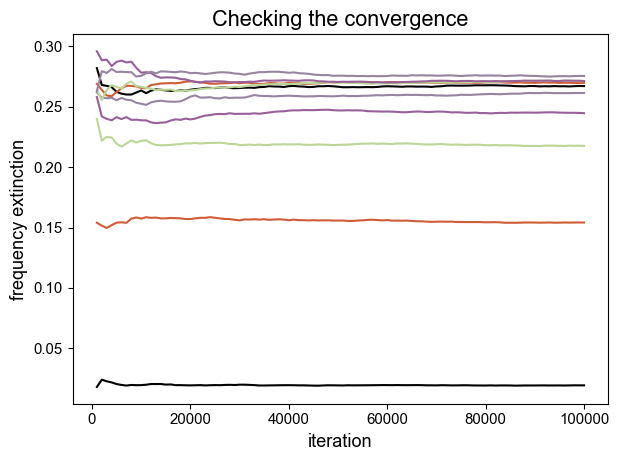

In [13]:
# Simulations (takes some time)
# -- Start with incipient lineage 
sim_param = {'n_sim':int(1e5), 'step':int(1e3), 'n_g0':0, 'n_i0':1}
horizons = np.linspace(0.1, 10, 10)
fig, ax = plt.subplots()

pIE_sim = np.zeros_like(horizons)
pIC_sim = np.zeros_like(horizons)

iter = np.linspace(sim_param['step'], sim_param['n_sim'], sim_param['n_sim'] // sim_param['step'])

for i in range(len(horizons)):
    sim = PBD_analog.simul_prot_etienne(**par, **sim_param, horizon=horizons[i])
    ax.plot(iter, sim["F_extinction"], label = str(i))
    pIE_sim[i] = np.sum(sim["Extinction"]) / len(sim["Extinction"])
    pIC_sim[i] = np.sum(sim["Speciation"]) / len(sim["Speciation"])
ax.set_xlabel("iteration")
ax.set_ylabel("frequency extinction")
ax.set_title("Checking the convergence");

c:\Users\pveron\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pveron\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


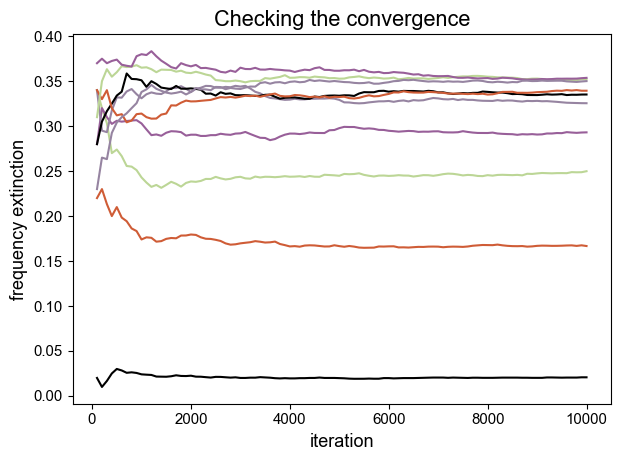

In [14]:
# Simulations (takes some time)
# -- Start with good lineage 
sim_param = {'n_sim':int(1e4), 'step':int(1e2), 'n_g0':1, 'n_i0':0}

fig, ax = plt.subplots()
pGE_sim = np.zeros_like(horizons)
pGS_sim = np.zeros_like(horizons)

iter = np.linspace(sim_param['step'], sim_param['n_sim'], sim_param['n_sim'] // sim_param['step'])

for i in range(len(horizons)):
    sim = PBD_analog.simul_prot_etienne(**par, **sim_param, horizon=horizons[i])
    ax.plot(iter, sim["F_extinction"], label = str(i))
    pGE_sim[i] = np.sum(sim["Extinction"]) / len(sim["Extinction"])
    pGS_sim[i] = np.sum(sim["Speciation"]) / len(sim["Speciation"])

ax.set_xlabel("iteration")
ax.set_ylabel("frequency extinction")
ax.set_title("Checking the convergence");

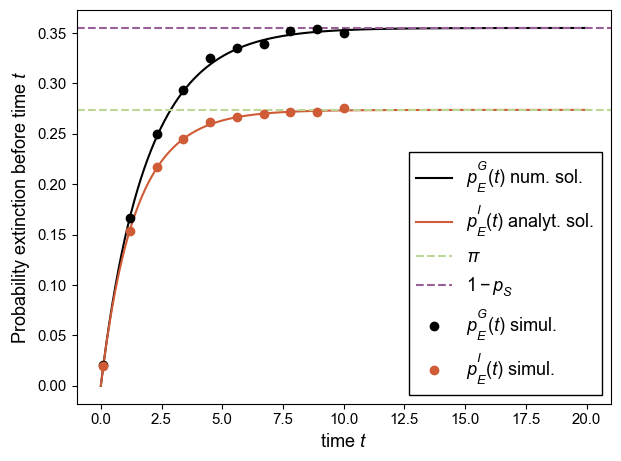

In [16]:
# Comparing predictions and simulations
fig, ax = plt.subplots()

ax.plot(T, pGE, label = "$p^G_E(t)$ num. sol.")
ax.plot(T, pIE, label = "$p^I_E(t)$ analyt. sol.")

ax.axhline(PBD_analog.pi(**par), ls = "--", color = colors[2], label = "$\pi$")
ax.axhline(1-PBD_analog.p_speciation(**par), ls = "--", color = colors[3], label = "$1 - p_S$")
ax.plot(horizons, pGE_sim, ls = "", marker = "o", color = "k", label = "$p^G_E(t)$ simul.")
ax.plot(horizons, pIE_sim, ls = "", marker = "o", color = colors[1], label = "$p^I_E(t)$ simul.")

ax.set_xlabel("time $t$")
ax.set_ylabel("Probability extinction before time $t$")
ax.legend(loc = "lower right")

## 3. Speciation/completion probabilities
Starting from an incipient, we will rather calculate the probability of not completing $1 - p_C^I(t)$. This event can be decomposed in three exclusive outcomes:
* direct extinction of the lineage in $[0,t]$, this happens with a probability $\frac{\mu_2}{\Lambda} (1 - e^{-\Lambda t})$, or
* the lineage survives until $t$ without completing, dying or making incipient lineages, this happens with probability $e^{-\Lambda t}$, or 
* the lineage makes an incipient at a time $u\le t$ and none of the incipient daughter lineages complete within the remaining time, the density probability of this outcome is $\lambda_3 e^{-\Lambda_u} ( 1 -p_C^I(t-u))^2$.


So we have the following equation:
\begin{align*}
    1 - p_C^I(t) &= \frac{\mu_2}{\Lambda} (1 - e^{-\Lambda t})  + e^{-\Lambda t} + \int_0^t \lambda_3 e^{-\Lambda_u} ( 1 -p_C^I(t-u))^2 du \\
    & = \frac{\mu_2}{\Lambda} (1 - e^{-\Lambda t})  + e^{-\Lambda t} + \lambda_3 e^{-\Lambda t} \int_0^t  e^{\Lambda u} ( 1 -p_C^I(u))^2 du
\end{align*} 

In [33]:
# Numerical solution for p^G_E(t)
pIC_comp = np.zeros_like(T)
integrand = np.full_like(T, np.nan)
integrand[0] = 1.0
pIC_comp[0] = 1.0

for i in range(1, len(T)):
    # Euler method
    elt = np.exp(-Lambda * T[i])
    pIC_comp[i] = m2 / Lambda * (1 - elt) + elt + l3 * elt * np.sum(integrand[:i])
    integrand[i] = (T[i] - T[i-1]) * np.exp(Lambda * T[i]) * (pIC_comp[i])**2
pIC = 1.0 - pIC_comp

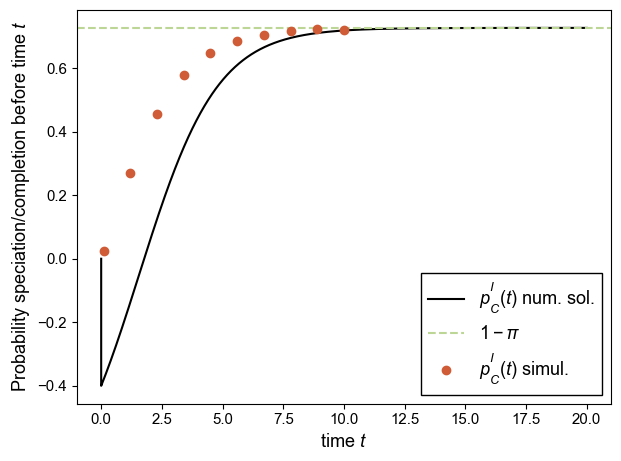

In [34]:
# Comparing predictions and simulations
fig, ax = plt.subplots()

#ax.plot(T, pGE, label = "$p^G_E(t)$ num. sol.")
ax.plot(T, pIC, label = "$p^I_C(t)$ num. sol.")

ax.axhline(1-PBD_analog.pi(**par), ls = "--", color = colors[2], label = "$1-\pi$")
#ax.axhline(1-PBD_analog.p_speciation(**par), ls = "--", color = colors[3], label = "$1 - p_S$")
#ax.plot(horizons, pGE_sim, ls = "", marker = "o", color = "k", label = "$p^G_E(t)$ simul.")
ax.plot(horizons, pIC_sim, ls = "", marker = "o", color = colors[1], label = "$p^I_C(t)$ simul.")

ax.set_xlabel("time $t$")
ax.set_ylabel("Probability speciation/completion before time $t$")
ax.legend(loc = "lower right")